In [1]:
# Created by: Chen Da
# Created on: 20191217

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings('ignore')

In [3]:
def split_func(data_frame, size=0.8):
    """
    Split the data into two data set
    :param data_frame: the name of input data
    :param size : the size of train data
    :return: train_data, test_data
    """
    data_frame = pd.DataFrame(data_frame.values,
                              index=[i for i in range(data_frame.values.shape[0])],
                              columns=data_frame.columns)
    healthy_data = data_frame[data_frame["class"] == 0]
    unhealthy_data = data_frame[data_frame["class"] == 1]
    healthy_index = list(healthy_data.index)
    unhealthy_index = list(unhealthy_data.index)
    healthy_train_data_index = random.sample(healthy_index, int(size * len(healthy_index)))
    unhealthy_train_data_index = random.sample(unhealthy_index, int(size * len(unhealthy_index)))
    healthy_test_data_index = list(set(healthy_index).difference(set(healthy_train_data_index)))
    unhealthy_test_data_index = list(set(unhealthy_index).difference(set(unhealthy_train_data_index)))
    train_index = list(set(healthy_train_data_index).union(set(unhealthy_train_data_index)))
    test_index = list(set(healthy_test_data_index).union(set(unhealthy_test_data_index)))
    train = data_frame.iloc[train_index, :]
    test = data_frame.iloc[test_index, :]
    return train, test

In [4]:
def balance_train(df, more_label=0, less_label=1):
    more_df = df[df['class']==more_label]
    less_df = df[df['class']==less_label]
    less_num = less_df.shape[0]
    more_index = list(more_df.index)
    index_choose = random.sample(more_index, less_num)
    df_choose = more_df.loc[index_choose, :]
    df_new = df_choose.append(less_df)
    return df_new

In [49]:
def final_model(df):
    predict_score = list()
    for info in range(df.shape[0]):
        new_data = df.iloc[info, :].values[1:-1]
        z = np.dot(new_data, coefs) + intercept
        y = 1 / (1 + np.exp(-z))
        predict_score.append(y)
    predict_df = pd.DataFrame(predict_score, columns=['pro'])
    df.index = [i for i in range(df.shape[0])]
    predict_df['id'] = df['id']
    predict_df['class'] = df['class']
    predict_df = predict_df.reindex(columns=['id', 'pro', 'class'])
    positive = predict_df[predict_df['class'] == 1]
    negtive = predict_df[predict_df['class'] == 0]
    plt.figure(figsize=(20, 12))
    plt.scatter(x=positive['id'], y=positive['pro'], color='red')
    plt.scatter(x=negtive['id'], y=negtive['pro'], color='blue')
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    print('混淆矩阵为%s' % [pre_0_right, pre_0_wrong, pre_1_right, pre_1_wrong])
    return predict_df

In [6]:
# path = 'C:/Users/pc/OneDrive/PLTTECH/Project/20191205_lung_cancer/'
path = '/Users/chenda/OneDrive/PLTTECH/Project/20191205_lung_cancer/'
# df_name = 'raw_data'
df_name = 'data_all'
df = pd.read_excel(path + 'rawdata/' + df_name + '.xlsx')
df['id'] = df['id'].apply(lambda x:str(x))
pnasSubsetsIndex = [0, 4, 5, 29, 43, 58, 60, 70, 71, 81, 91, 95, 96, 98, 99, 101, 62, 64, 76, 77, 89, 90, 103]       
df = df.iloc[:, pnasSubsetsIndex]
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].multiply(100)
stdsc = StandardScaler()
df.iloc[:, 1:-1] = pd.DataFrame(stdsc.fit_transform(df.iloc[:, 1:-1].values), columns=df.columns[1:-1])
df.shape

(299, 23)

In [7]:
df[df['class']==1].shape

(105, 23)

In [15]:
## 划分训练集和测试集
train_df, test_df = split_func(df)
train_df = balance_train(train_df, more_label=0, less_label=1)
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['class'].values.astype('int')
X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['class'].values.astype('int')
# X_train = df.iloc[:, 1:-1].values
# y_train = df['class'].values.astype('int')

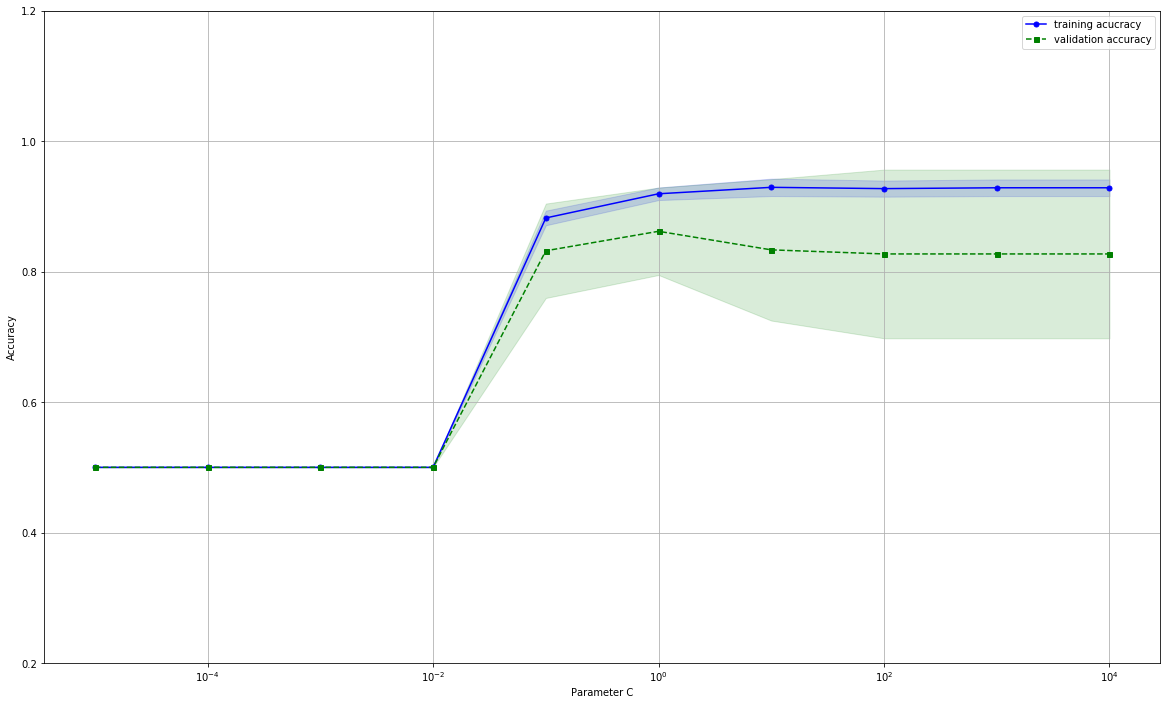

In [16]:
# 通过验证曲线来确定正则参数
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2)
clf = LogisticRegression(penalty='l1')
# param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_range = [10**i for i in range(-5, 5)]
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, 
                                             y=y_train,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,12))
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training acucracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.show()                # 图形观察出最优正则参数在0.1附近

In [17]:
# lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.2, C=0.01)
lr = LogisticRegression(penalty='l1', C=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# help(LogisticRegression)

In [19]:
lr.score(X_train, y_train)

0.9226190476190477

In [20]:
lr.score(X_test, y_test)

0.9166666666666666

In [21]:
coefs = list(lr.coef_[0])
intercept = lr.intercept_[0]
select_subsets_id = [list(lr.coef_[0]).index(i) for i in list(lr.coef_[0]) if i != 0]
select_subsets = [list(df.columns[1:-1])[i] for i in select_subsets_id]
print(len(select_subsets))
select_subsets.append('class')
select_subsets.insert(0, 'id')
print(select_subsets)
coefs = [i for i in coefs if i != 0]
print(coefs)
print(intercept)

15
['id', 'Lymphocytes/CD3+', 'Lymphocytes/CD3+/CD4+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3+/CD8+', 'Lymphocytes/CD3+/CD8+/HLA-DR+', 'Lymphocytes/CD3+/CD8+/PD1+', 'Lymphocytes/CD3-', 'Lymphocytes/CD3-/B cells', 'Lymphocytes/CD3-/NK cells', 'Myeloid cells/CD56-CD14-/DC cells/mDC', 'Myeloid cells/CD56-CD14-/DC cells/pDC', 'Myeloid cells/HLA-DR-/MDSC', 'Lymphocytes/CD3+/CD8+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3+/CD8+/Q4: 158Gd_CD197_CCR7- , 155Gd_CD45RA-', 'Lymphocytes/CD3-/B cells/Q2: 145Nd_IgD+ , 153Eu_CD27+', 'Lymphocytes/gd T-cells', 'class']
[-0.16203293595614363, -0.7678291609941217, -0.517354123416592, 0.33944064564347026, 0.5282916369975494, 0.43491361818836866, 0.38938322765168903, -1.0798498412173547, 1.2497354719130704, -0.4739491190156478, 0.5524007110010045, -0.183613866863311, 0.0009962388440108508, -0.5140127766135673, -0.37509801076848537]
-0.9021815611830093


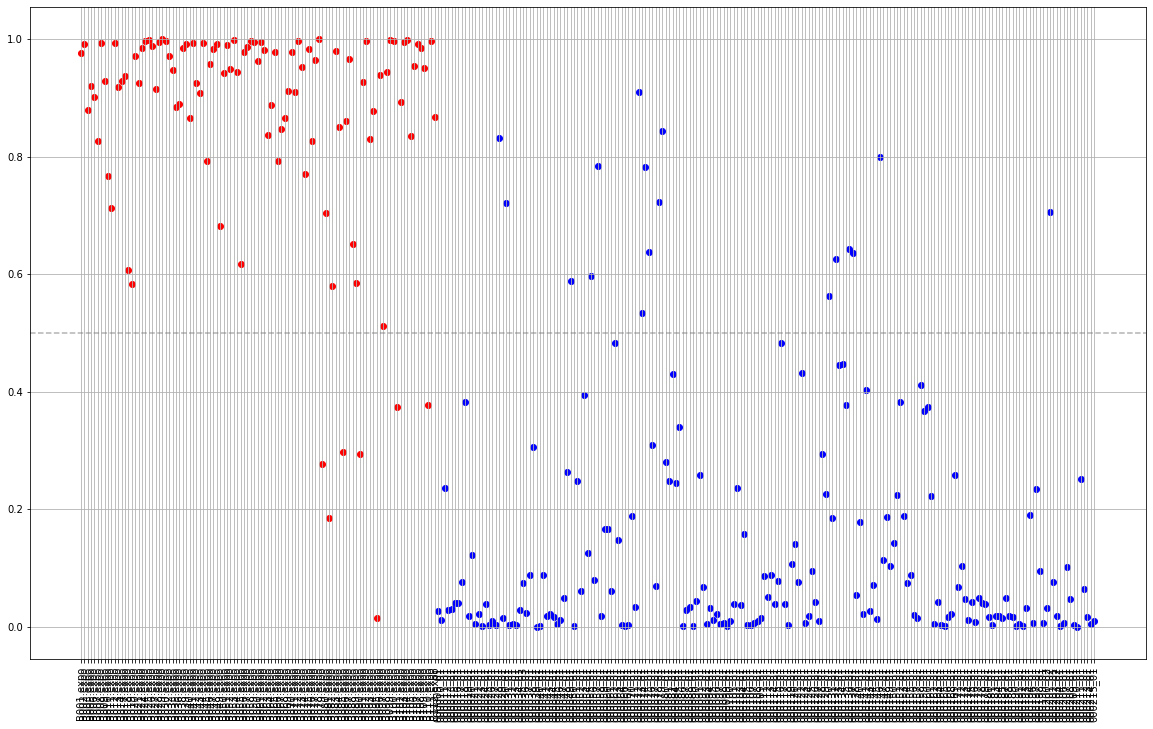

总体准确率为0.919732441471572
混淆矩阵为[177, 17, 98, 7]


In [53]:
pre_df = final_model(df.loc[:, select_subsets])

In [55]:
177/194

0.9123711340206185

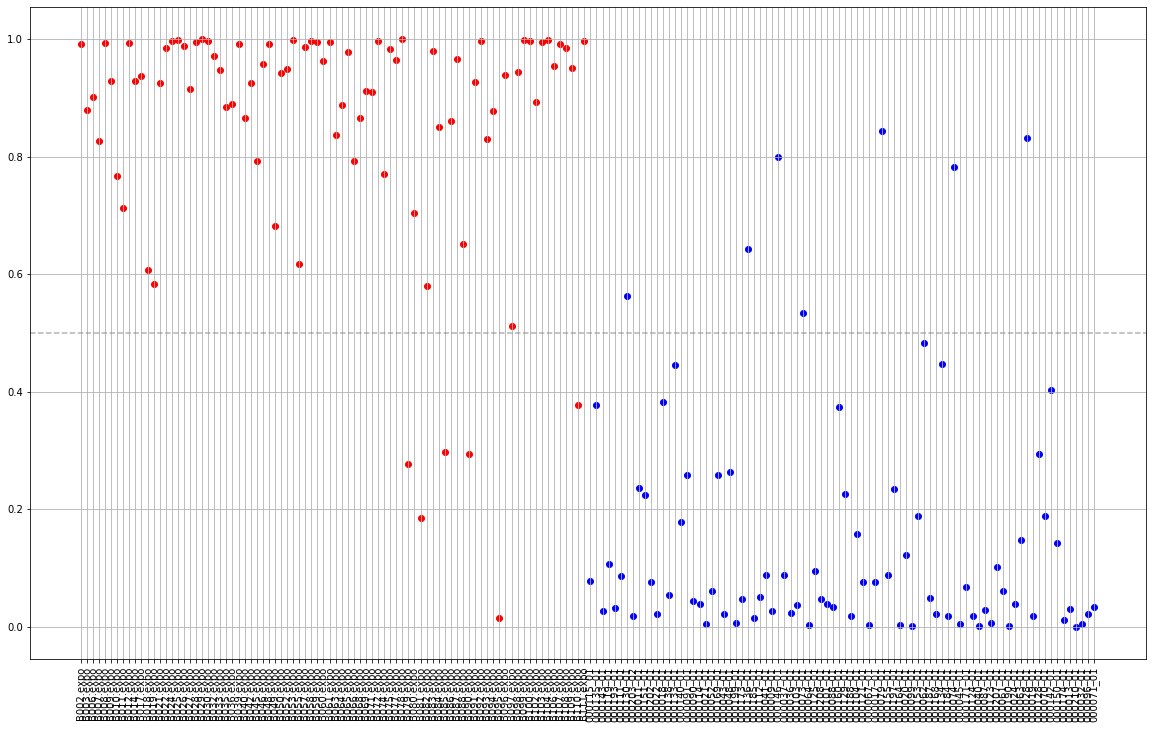

总体准确率为0.9226190476190477
混淆矩阵为[77, 7, 78, 6]


In [51]:
pre_train = final_model(train_df.loc[:, select_subsets])

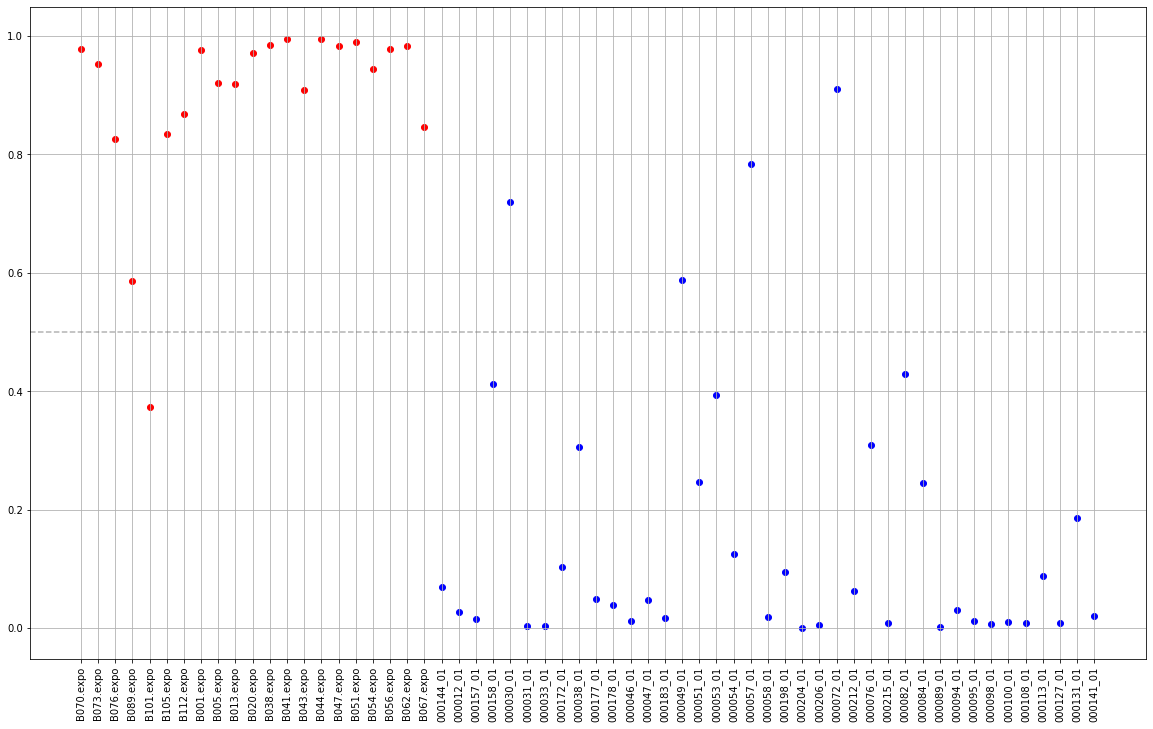

总体准确率为0.9166666666666666
混淆矩阵为[35, 4, 20, 1]


In [52]:
pre_test = final_model(test_df.loc[:, select_subsets])

In [26]:
pre_train.head()

,id,pro,class,pre_label
0,000115_01,0.077486,0,0
1,000135_01,0.376521,0,0
2,000143_01,0.027133,0,0
3,000119_01,0.106953,0,0
4,000193_01,0.031427,0,0


In [44]:
def roc_plot(real_score, predict_score, title):
    fpr, tpr, threshold = roc_curve(real_score, predict_score)
    roc_auc = auc(fpr, tpr)
    print("AUC is %s" % roc_auc)
    plt.figure(dpi=400)
    plt.plot(fpr, tpr, color='green', lw=2,
             label='ROC curve\nAUC:%0.3f' % roc_auc)
    plt.plot([0,1], [0,1], color=(0.6, 0.6, 0.6), lw=2, linestyle='--')
    plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='grey')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s' % title)
    plt.legend(loc='lower right')
    plt.savefig('/Users/chenda/Desktop/%s.png' % title)
    plt.show()

AUC is 0.9804639804639804


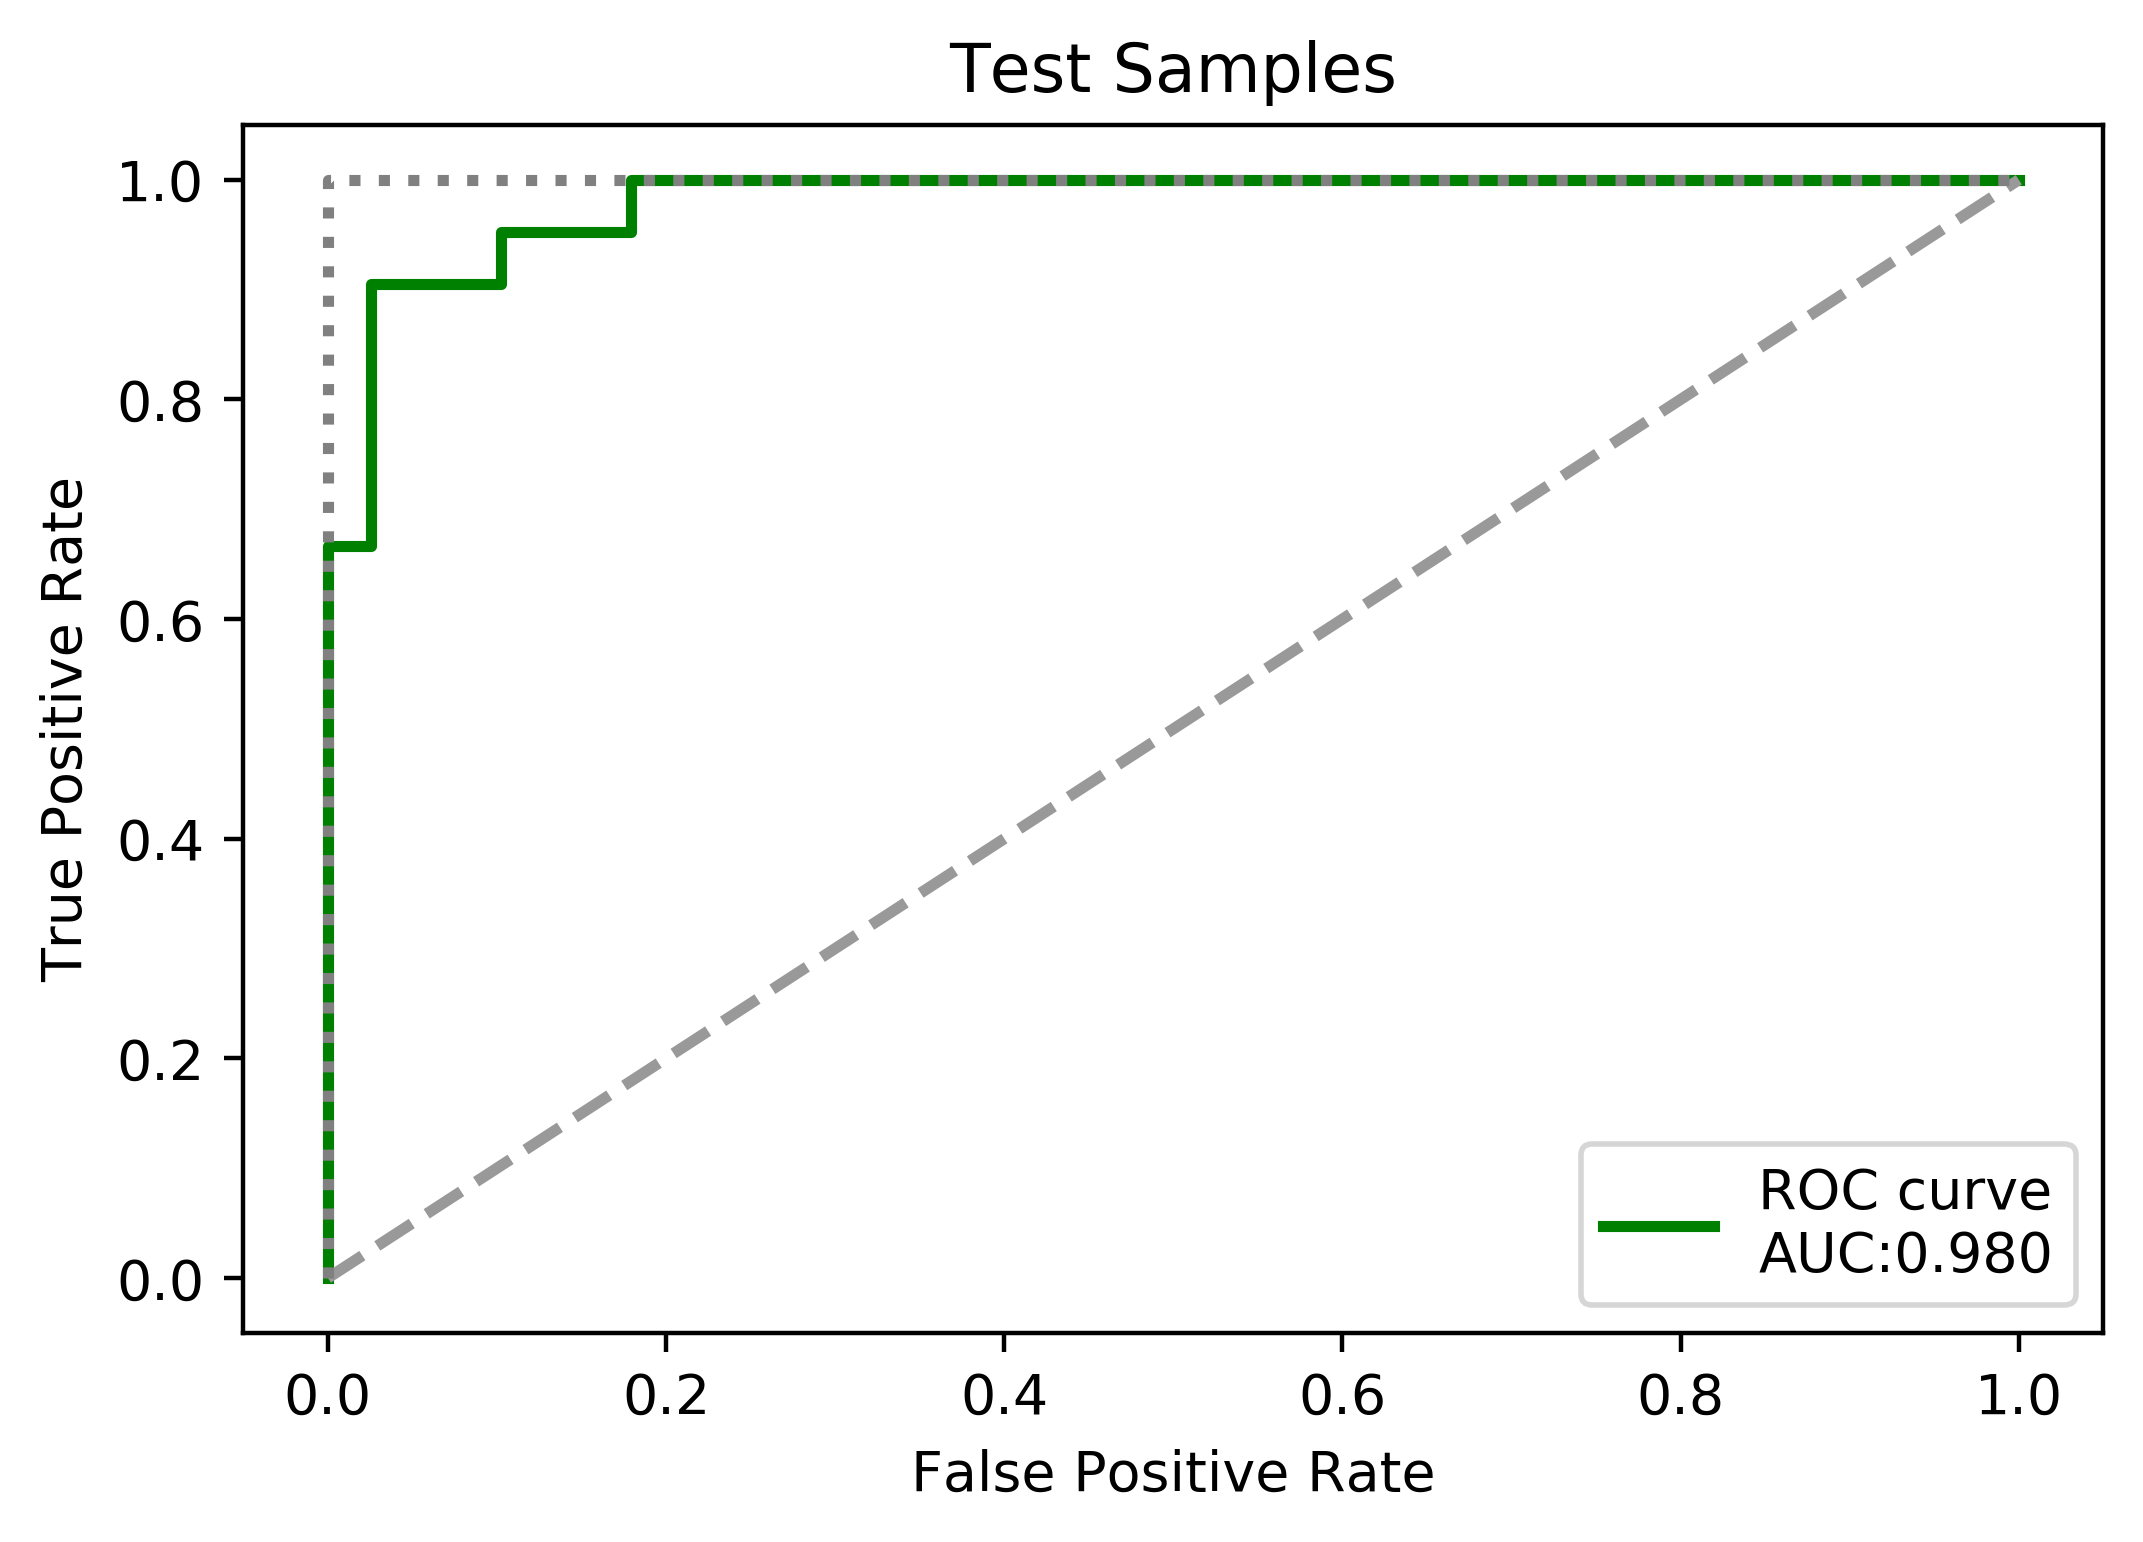

In [48]:
roc_plot(list(pre_test['class'].values), list(pre_test['pro'].values), title='Test Samples')

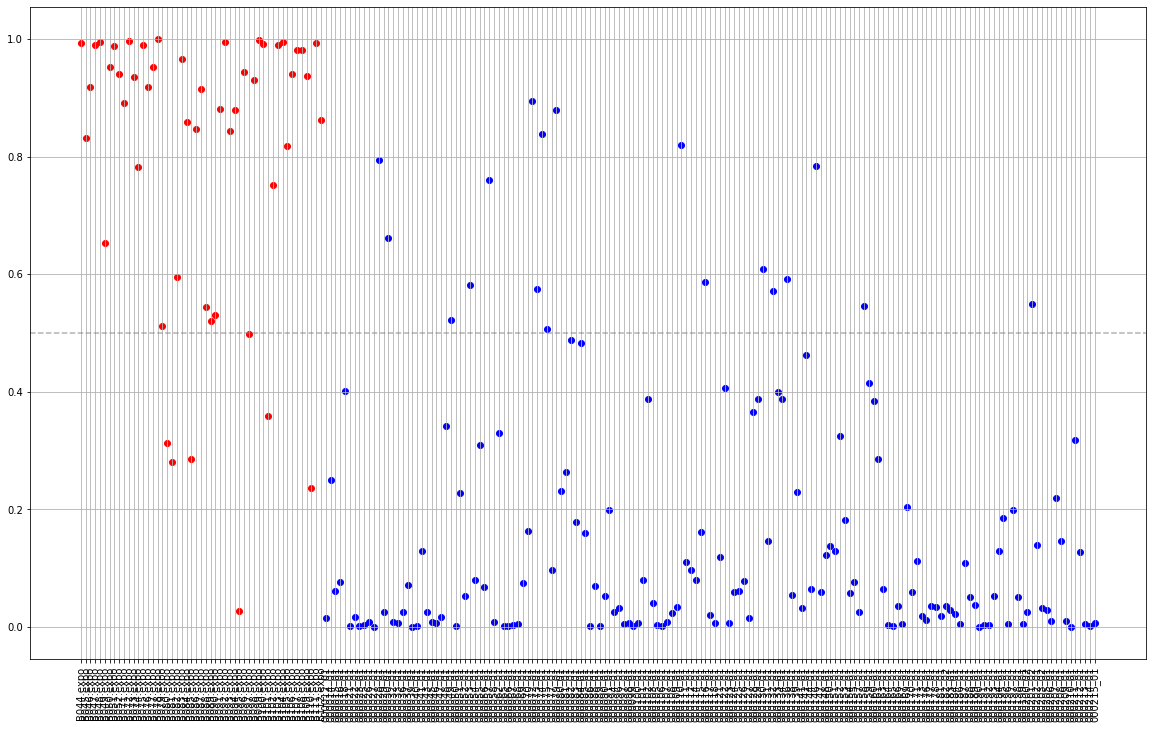

总体准确率为0.8820754716981132


In [63]:
test_all = pd.read_excel(path + 'rawdata/test_all.xlsx')
test_all = test_all.iloc[:, pnasSubsetsIndex]
test_all.iloc[:, 1:-1] = test_all.iloc[:, 1:-1].multiply(100)
test_all.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(test_all.iloc[:, 1:-1].values), columns=test_all.columns[1:-1])
test_all = test_all.loc[:, select_subsets]
pre_test_all = final_model(test_all)

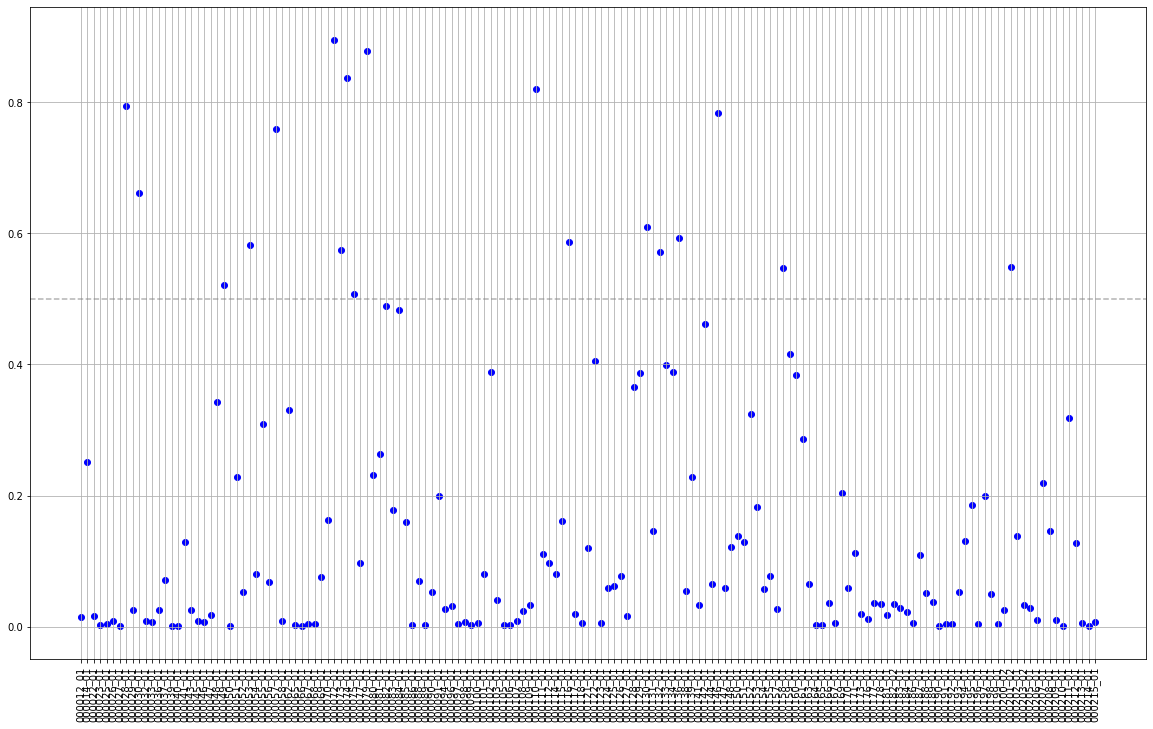

总体准确率为0.8853503184713376


In [64]:
healthy_new = pd.read_excel(path + 'rawdata/test_healthy_new.xlsx')
healthy_new = healthy_new.iloc[:, pnasSubsetsIndex]
healthy_new.iloc[:, 1:-1] = healthy_new.iloc[:, 1:-1].multiply(100)
healthy_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(healthy_new.iloc[:, 1:-1].values), columns=healthy_new.columns[1:-1])
healthy_new = healthy_new.loc[:, select_subsets]
pre_healthy_new = final_model(healthy_new)

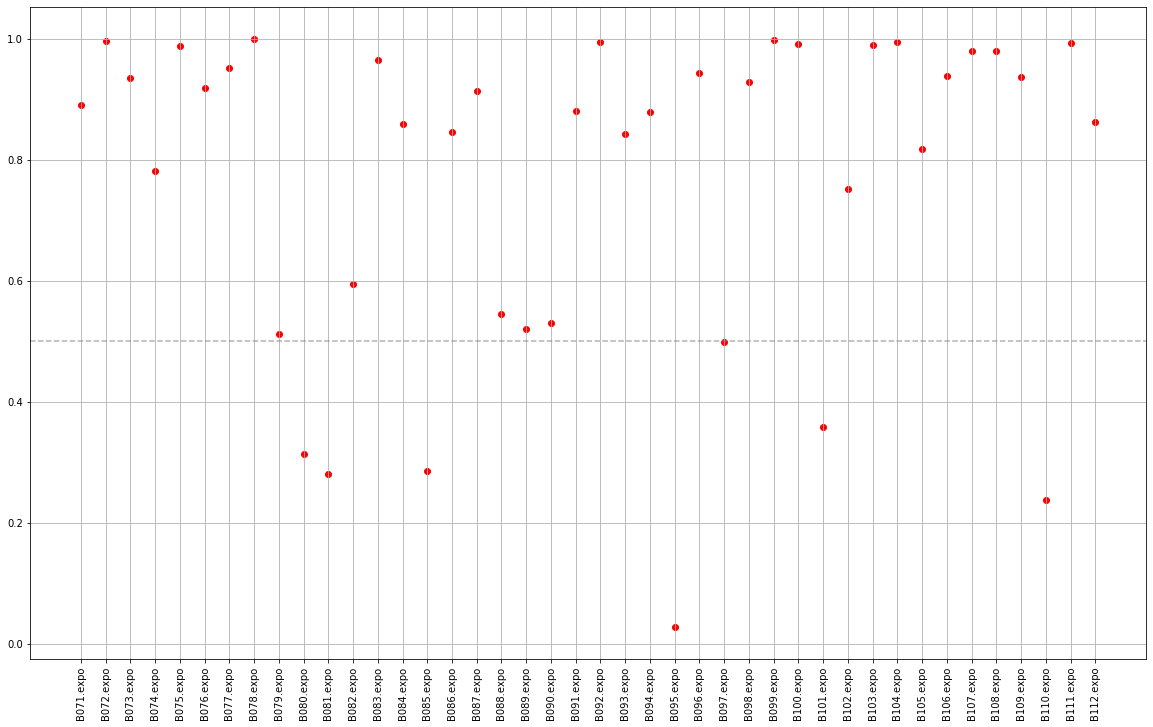

总体准确率为0.8333333333333334


In [65]:
lung_cancer_new = pd.read_excel(path + 'rawdata/test_lung_cancer_new.xlsx')
lung_cancer_new = lung_cancer_new.iloc[:, pnasSubsetsIndex]
lung_cancer_new.iloc[:, 1:-1] = lung_cancer_new.iloc[:, 1:-1].multiply(100)
lung_cancer_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(lung_cancer_new.iloc[:, 1:-1].values), columns=lung_cancer_new.columns[1:-1])
lung_cancer_new = lung_cancer_new.loc[:, select_subsets]
pre_lung_cancer_new = final_model(lung_cancer_new)

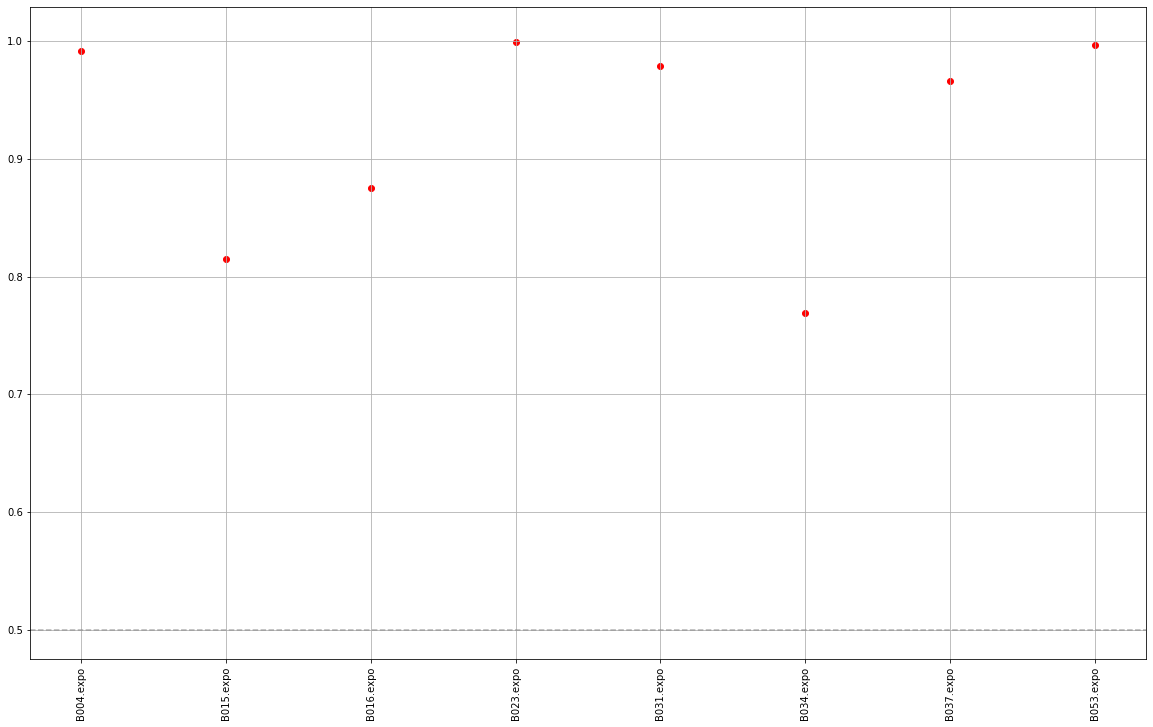

总体准确率为1.0


In [67]:
benign_new = pd.read_excel(path + 'rawdata/test_benign.xlsx')
benign_new = benign_new.iloc[:, pnasSubsetsIndex]
benign_new.iloc[:, 1:-1] = benign_new.iloc[:, 1:-1].multiply(100)
benign_new.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(benign_new.iloc[:, 1:-1].values), columns=benign_new.columns[1:-1])
benign_new = benign_new.loc[:, select_subsets]
pre_benign_new = final_model(benign_new)

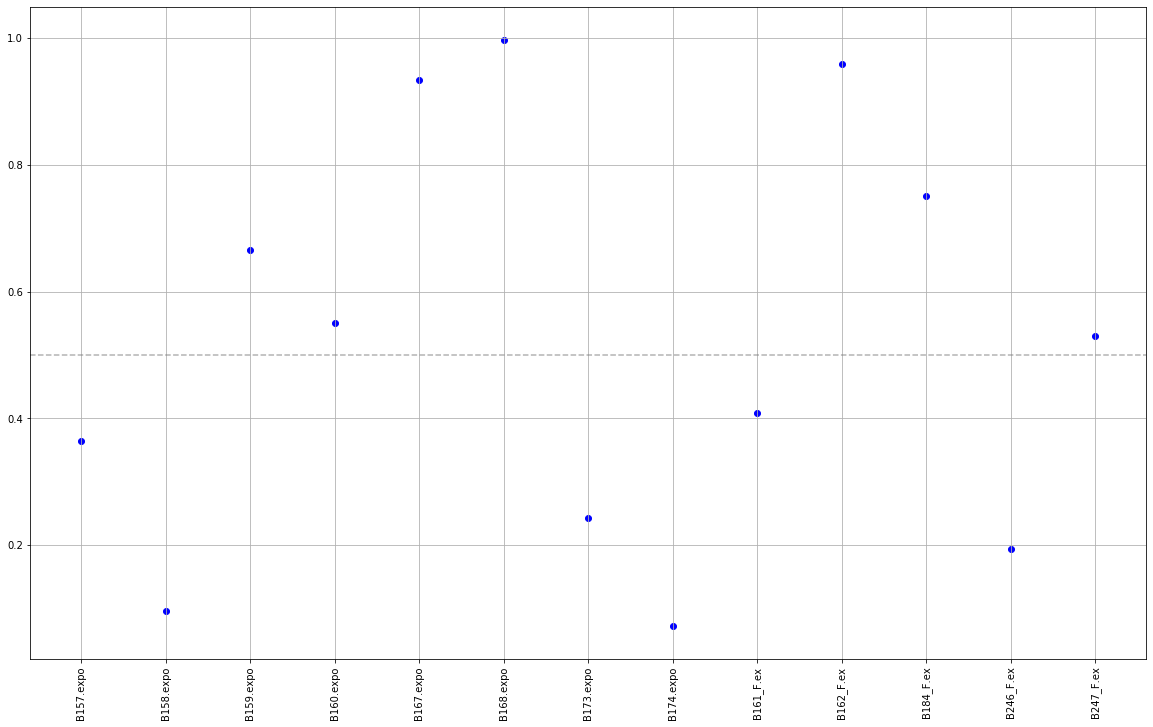

总体准确率为0.46153846153846156


In [68]:
pulmonary_nodule = pd.read_excel(path + 'rawdata/test_pulmonary_nodule.xlsx')
pulmonary_nodule = pulmonary_nodule.iloc[:, pnasSubsetsIndex]
pulmonary_nodule.iloc[:, 1:-1] = pulmonary_nodule.iloc[:, 1:-1].multiply(100)
pulmonary_nodule.iloc[:, 1:-1] = pd.DataFrame(stdsc.transform(pulmonary_nodule.iloc[:, 1:-1].values), columns=pulmonary_nodule.columns[1:-1])
pulmonary_nodule = pulmonary_nodule.loc[:, select_subsets]
pre_pulmonary_nodule = final_model(pulmonary_nodule)

In [142]:
# PLT_healthy_new = pd.read_excel(path + 'rawdata/test_PLT_healthy.xlsx').loc[:, select_subsets]
# PLT_healthy_new.iloc[:, 1:-1] = PLT_healthy_new.iloc[:, 1:-1].multiply(100)
# pre_PLT = final_model(PLT_healthy_new)